In [108]:
import os.path
import glob
import pandas as pd
from biom import Table, load_table

import warnings

from qiime2.plugins.feature_table.methods import (rarefy, filter_samples, filter_features,
                                                  merge, relative_frequency, filter_features_conditionally,
                                                 group)

from qiime2.plugins.feature_table.visualizers import summarize

from qiime2 import Artifact
from qiime2 import Metadata


from skbio import OrdinationResults, TreeNode, DistanceMatrix
from qiime2.plugins.gemelli.actions import (rpca, phylogenetic_rpca_without_taxonomy,
                                            phylogenetic_rpca_with_taxonomy)
from qiime2.plugins.emperor.actions import plot, biplot
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.pipelines import (alpha,
                                                alpha_phylogenetic)
from qiime2.plugins.diversity.visualizers import (alpha_rarefaction,adonis,beta_group_significance)
from qiime2.plugins.diversity.methods import pcoa
from qiime2.plugins import taxa

from qiime2.plugins import emperor
from qiime2.plugins.empress.actions import community_plot

from assets.step_wise_anova import run_stepwise_anova

from skbio.stats.distance import permanova, bioenv
import statsmodels.stats.multitest as multi 
from scipy.optimize import curve_fit
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import re

from statannotations.Annotator import Annotator

In [109]:
# classifier
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import (roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
# stats
from statsmodels.stats.contingency_tables import mcnemar


In [110]:
metadata_df = pd.read_csv('./metadata/2023_03_21_3DMM_metadata_to_update_qiita.txt',sep='\t').set_index('#SampleID')

In [215]:
#cleaning un sample_names to exclude a wetlab preparation indetifier (prefix)
metadata_df.index = metadata_df.index.str.replace('150297.','').str.replace('151322.','')

/var/folders/90/7sftvg657kdcfk9d88mj7zph0000gp/T/ipykernel_15505/679765002.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata_df.index = metadata_df.index.str.replace('150297.','').str.replace('151322.','')


# CARD

File size limits on GitHub prevent me from depositing the full CARD output to enable running the following modules. Nonetheless, I've included them for reference and transparency. 

In [216]:
#The following functions and modules were used to generate stats and feature_tables
#from raw CARD output files. 

In [217]:
# #list of file directories from CARD output
# files_3dmm = pd.read_csv('./metadata/3DMM_files.csv',header=None,
#                          names=['sample_name','barcode','r1','r2'])

In [218]:
# def read_report_from_file(file_path):
#     try:
#         # Read the contents of the file
#         with open(file_path, 'r') as file:
#             report_text = file.read()
#         return report_text
#     except FileNotFoundError:
#         print("Error: File not found.")
#         return None


# def extract_mapped_reads_percentage(report_text):
#     # Define the regular expression pattern to match the percentage of mapped reads
#     pattern = r"Mapped reads:\s+\d+\s+\((\d+\.\d+)%\)"
    
#     # Search for the pattern in the report text
#     match = re.search(pattern, report_text)
    
#     if match:
#         # Extract the percentage value from the matched group
#         percentage = float(match.group(1))
#         return percentage
#     else:
#         return None
    

# def extract_total_reads(report_text):
#     # Define the regular expression pattern to match the "Total reads" line
#     pattern = r"Total reads:\s+(\d+)"
    
#     # Search for the pattern in the report text
#     match = re.search(pattern, report_text)
    
#     if match:
#         # Extract the total reads count from the matched group
#         total_reads = int(match.group(1))
#         return total_reads
#     else:
#         return None

In [219]:
# for sample_name in files_3dmm['barcode']:
#     directory_ = f'/panfs/rsalidob/metagenomics/CARD/{sample_name}.overall_mapping_stats.txt'
#     report = read_report_from_file(directory_)
#     if report is None:
#         files_3dmm.loc[files_3dmm['barcode']==sample_name,
#                                 'AMR_mapped_reads (%)']=np.nan
#     else:
#         mapped_reads = extract_mapped_reads_percentage(report)
#         files_3dmm.loc[files_3dmm['barcode']==sample_name,
#                                 'AMR_mapped_reads (%)']=mapped_reads

In [220]:
#Import results from above modules from file
files_3dmm = pd.read_csv('./data/3DMM_AMR_mapped_reads.csv')

/Users/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMR_mapped_reads (%)', ylabel='Density'>

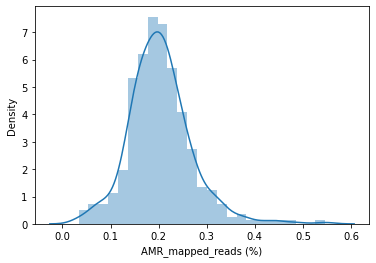

In [221]:
sns.distplot(files_3dmm['AMR_mapped_reads (%)'])

In [222]:
#Importing alpha diversity results from file
metadata_w_alpha = pd.read_csv('./data/alphadiv_16s_w_metadata.csv')
metadata_w_alpha['Unnamed: 0'] = metadata_w_alpha['Unnamed: 0'].str.replace('150297.','').str.replace('151322.','')
metadata_w_alpha.set_index('Unnamed: 0',inplace=True)

/var/folders/90/7sftvg657kdcfk9d88mj7zph0000gp/T/ipykernel_15505/2815587897.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata_w_alpha['Unnamed: 0'] = metadata_w_alpha['Unnamed: 0'].str.replace('150297.','').str.replace('151322.','')


In [223]:
files_3dmm_merged  = files_3dmm.merge(metadata_w_alpha,right_index=True,left_on= 'sample_name')

In [224]:
for module in files_3dmm_merged['module'].unique():
    module_median = files_3dmm_merged.loc[files_3dmm_merged['module']==module,'AMR_mapped_reads (%)'].median()
    files_3dmm_merged.loc[files_3dmm_merged['module']==module,'AMR_percent_median'] = module_median

/Users/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

US Lab vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.681e-01 U_stat=7.930e+02
Node 1 vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.459e-01 U_stat=3.312e+03
JLP vs. JPM: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.059e-05 U_stat=9.200e+01
PMM vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.030e-01 U_stat=2.644e+03
JPM vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.690e-01 U_stat=6.490e+02
Node 1 vs. Airlock: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.198e-01 U_stat=1.680e+02
Columbus vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjam

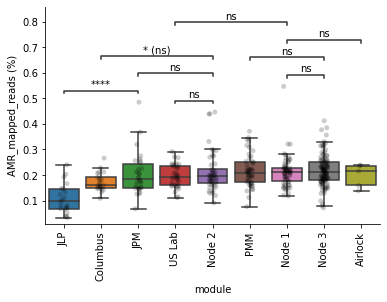

In [225]:
order_ = files_3dmm_merged.sort_values(by='AMR_percent_median')['module'].unique()
#pairs were defined by physical interconnectedness of modules 

ax1 = plt.subplot(111)



sns.boxplot(x='module',y='AMR_mapped_reads (%)',data=files_3dmm_merged.sort_values(by='AMR_percent_median'),fliersize=0,ax=ax1)
sns.stripplot(x='module',y='AMR_mapped_reads (%)',data=files_3dmm_merged.sort_values(by='AMR_percent_median'),color='black',alpha=0.2,ax=ax1)
plt.xticks(rotation=90)

# ax1.set_ylim(0,0.7)
pairs = [('JPM','JLP'),('Node 3','PMM'),('Node 2','JPM'),('Node 2','Columbus'),('Node 2','US Lab'),
        ('Node 1','US Lab'),('Airlock','Node 1'),('Node 1','Node 3')]
annot = Annotator(ax1, pairs, data=files_3dmm_merged, x='module', y='AMR_mapped_reads (%)', order=order_)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2,comparisons_correction='fdr_bh')
annot.apply_test()
ax1, test_results = annot.annotate()

ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['top'].set_visible(False)
plt.savefig('./figs/Fig_6_panel_A.svg')

In [226]:
files_3dmm_merged['AMR_mapped_reads (%)'].describe()

count    384.000000
mean       0.204423
std        0.067346
min        0.033687
25%        0.161430
50%        0.198771
75%        0.236426
max        0.546480
Name: AMR_mapped_reads (%), dtype: float64

In [227]:
print(f"There is a median of {round(0.198771, 2)}% AMR mapped reads per sample")


There is a median of 0.2% AMR mapped reads per sample


In [228]:
module_colors= {'Airlock':'tab:red',
               'Columbus':'tab:blue',
               'JLP':'tab:orange',
               'JPM':'tab:green',
               'US Lab':'cadetblue',
               'Node 1':'tab:purple',
               'Node 2':'yellow',
               'Node 3':'tab:cyan',
               'PMM':'tab:pink'}

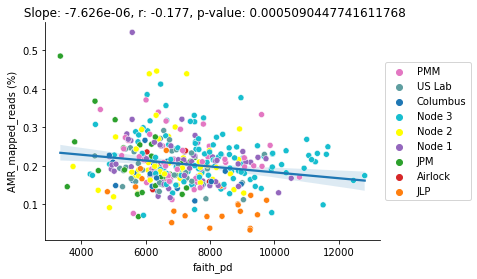

In [229]:
cat_ = 'faith_pd'
ax = plt.subplot(111)
sns.regplot(x=cat_,y='AMR_mapped_reads (%)',data=files_3dmm_merged,scatter=False)
sns.scatterplot(x=cat_,y='AMR_mapped_reads (%)',data=files_3dmm_merged,hue='module',palette=module_colors)

res = stats.linregress(files_3dmm_merged[cat_],
                       files_3dmm_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
plt.xlabel(cat_)
plt.ylabel('AMR_mapped_reads (%)')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

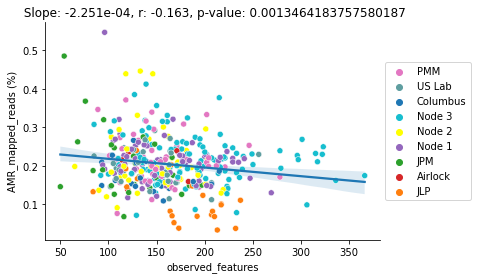

In [230]:
cat_ = 'observed_features'
ax = plt.subplot(111)
sns.regplot(x=cat_,y='AMR_mapped_reads (%)',data=files_3dmm_merged,scatter=False)
sns.scatterplot(x=cat_,y='AMR_mapped_reads (%)',data=files_3dmm_merged,hue='module',palette=module_colors)

res = stats.linregress(files_3dmm_merged[cat_],
                       files_3dmm_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
plt.xlabel(cat_)
plt.ylabel('AMR_mapped_reads (%)')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [231]:
##GitHub file size restriction prevent inclusion of full CARD out put directory. Importing results from
##Running this module from file instead. 

# AMR_mapped_reads = 0
# amr_3dmm_df = pd.DataFrame()
# amr_metadata_3dmm_df = pd.DataFrame()
# for sample_name in files_3dmm['barcode']:
#     directory_ = f'/panfs/rsalidob/metagenomics/CARD/{sample_name}.overall_mapping_stats.txt'
#     report = read_report_from_file(directory_)
#     total_reads = extract_total_reads(report)
#     table = pd.read_csv(f'/panfs/rsalidob/metagenomics/CARD/{sample_name}.gene_mapping_data.txt',sep='\t')
#     amr_metadata = table[['ARO Term','ARO Accession','Reference Model Type',
#                           'Reference DB','Resistomes & Variants: Observed Pathogen(s)',
#                           'AMR Gene Family','Drug Class', 'Resistance Mechanism']]
#     amr_count_table = table[['ARO Term','All Mapped Reads']].T
#     amr_count_table.columns = amr_count_table.loc['ARO Term']
#     amr_count_table.columns.name=None
#     amr_count_table.index.name = 'sample_name'
#     amr_count_table.drop(index='ARO Term',inplace=True)
#     amr_count_table.rename(index={'All Mapped Reads':sample_name},inplace=True)
#     AMR_mapped_reads += int(amr_count_table.sum(axis=1))
#     amr_count_table = amr_count_table/total_reads
#     amr_3dmm_df = pd.concat([amr_3dmm_df,amr_count_table])
#     amr_metadata_3dmm_df = pd.concat([amr_metadata_3dmm_df,amr_metadata])
# amr_metadata_3dmm_df = amr_metadata_3dmm_df.set_index('ARO Term')
# amr_metadata_3dmm_df = amr_metadata_3dmm_df[~amr_metadata_3dmm_df.index.duplicated(keep='first')]

In [232]:
amr_3dmm_df = pd.read_csv('./data/3DMM_AMR_feature_table.csv').set_index('sample_name')

In [233]:
amr_metadata_3dmm_df = pd.read_csv('./metadata/3DMM_AMR_metadata.csv').set_index('ARO Term')

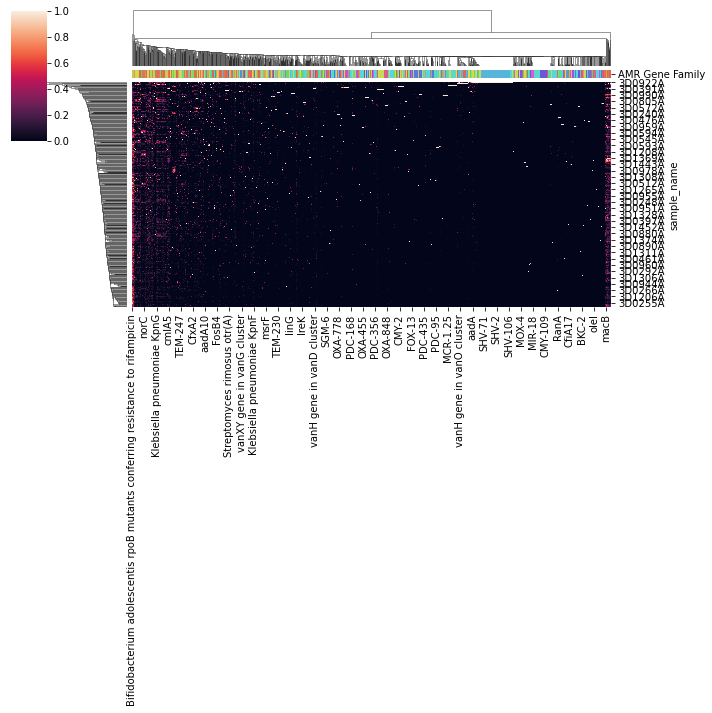

In [234]:
lut = dict(zip(amr_metadata_3dmm_df['AMR Gene Family'].unique(),
               sns.hls_palette(len(set(amr_metadata_3dmm_df['AMR Gene Family'])))))
col_colors = amr_metadata_3dmm_df['AMR Gene Family'].map(lut)
sns.clustermap(amr_3dmm_df.fillna(0),standard_scale=1,col_colors=col_colors)

In [235]:
print(f"{len(set(amr_3dmm_df.columns))} number of unique columns")
print(f"{len(set(amr_3dmm_df.index))} number of unique samples")

1065 number of unique columns
393 number of unique samples


In [236]:
amr_3dmm_df.shape

(393, 1065)

In [237]:
amr_3dmm_df.sum(axis=1)

sample_name
3D0416A    0.003296
3D0245A    0.003144
3D1004A    0.001872
3D0203A    0.002396
3D0492A    0.001861
             ...   
3D1356A    0.003520
3D0207A    0.001672
3D0248A    0.003317
3D1311A    0.002448
3D0854A    0.001219
Length: 393, dtype: float64

In [238]:
ft_df = pd.DataFrame(amr_3dmm_df.sum(axis=1),columns=['%'])

ft_df_merged = ft_df.merge(files_3dmm_merged,left_index=True, right_on='barcode_x')
ft_df_merged['%'] = ft_df_merged['%'] * 100 #to turn into %

<AxesSubplot:title={'center':' Slope: 7.924e-01, r: 0.994, p-value: 0.0'}, xlabel='%', ylabel='AMR_mapped_reads (%)'>

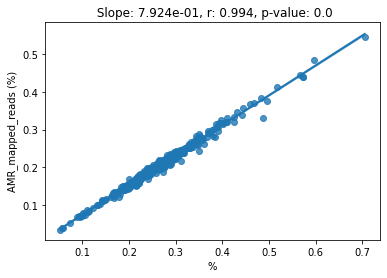

In [239]:
#Sanity check regression between AMR_mapped_reads calculated earlier and 
#sum of relative abundances in feature_table. 
res = stats.linregress(ft_df_merged['%'],
                       ft_df_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
sns.regplot(x='%',y='AMR_mapped_reads (%)',data=ft_df_merged)

In [240]:
amr_3dmm_ft = amr_3dmm_df.merge(metadata_df[['tube_barcode']],left_index=True,right_on='tube_barcode')
amr_3dmm_ft.drop(columns='tube_barcode',inplace=True)

In [241]:
amr_3dmm_ft.shape

(393, 1065)

In [242]:
amr_3dmm_ft = amr_3dmm_ft.drop_duplicates()

In [243]:
amr_3dmm_ft.shape

(392, 1065)

In [244]:
len(set(amr_3dmm_ft.columns))

1065

In [245]:
for sample in amr_3dmm_ft.index:
    amr_n =sum(amr_3dmm_ft.loc[sample]>0)
    amr_3dmm_ft.loc[sample,'AMR gene count']=amr_n


In [246]:
amr_3dmm_ft['AMR gene count'].describe()

count    392.000000
mean     111.438776
std       47.500506
min       33.000000
25%       77.000000
50%       99.500000
75%      142.250000
max      357.000000
Name: AMR gene count, dtype: float64

/Users/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMR gene count', ylabel='Density'>

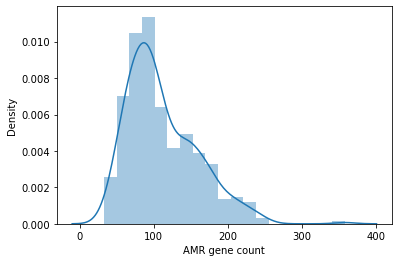

In [247]:
sns.distplot(amr_3dmm_ft['AMR gene count'])

In [248]:
#introduce "Other" genes column to add relative abundances up to 1
amr_3dmm_ft['other'] = 1 - amr_3dmm_ft.sum(1)

In [249]:
amr_metadata_3dmm_df

,ARO Accession,Reference Model Type,Reference DB,Resistomes & Variants: Observed Pathogen(s),AMR Gene Family,Drug Class,Resistance Mechanism
ARO Term,,,,,,,
srmB,3002828,protein homolog model,CARD,Streptomyces ambofaciens,Miscellaneous ABC-F subfamily ATP-binding cass...,macrolide antibiotic,antibiotic target protection
vgaALC,3002830,protein homolog model,CARD; Resistomes & Variants,Staphylococcus haemolyticus; Enterobacter horm...,vga-type ABC-F protein,lincosamide antibiotic; streptogramin antibiot...,antibiotic target protection
mtrE,3000812,protein homolog model,CARD,Neisseria gonorrhoeae,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; penam,antibiotic efflux
macB,3000535,protein homolog model,CARD; Resistomes & Variants,Neisseria gonorrhoeae,ATP-binding cassette (ABC) antibiotic efflux pump,macrolide antibiotic,antibiotic efflux
vgaA,3002829,protein homolog model,CARD,Staphylococcus aureus,vga-type ABC-F protein,lincosamide antibiotic; streptogramin antibiot...,antibiotic target protection
...,...,...,...,...,...,...,...
SHV-225,3005241,protein homolog model,Resistomes & Variants,Klebsiella pneumoniae,SHV beta-lactamase,carbapenem; cephalosporin; penam,antibiotic inactivation
aadA4,3002604,protein homolog model,Resistomes & Variants,Salmonella enterica,ANT(3''),aminoglycoside antibiotic,antibiotic inactivation
aadA12,3002612,protein homolog model,Resistomes & Variants,Pseudomonas aeruginosa,ANT(3''),aminoglycoside antibiotic,antibiotic inactivation


In [250]:
def find_substring_in_tuple(my_tuple, substring):
    # Iterate over each item in the tuple
    for item in my_tuple:
        # Check if the substring is in the current item
        if substring in item:
            # If found, return the item
            return item
    # If the substring is not found, return None or an appropriate message
    return None

megares_mapper_df = pd.read_csv('./metadata/megares_to_external_header_mappings_v3.00.csv')
megares_mapper_df = megares_mapper_df.loc[megares_mapper_df['Database']=='CARD']
mapping_df = pd.DataFrame(columns=['ARO', 'MEG', 'AMR class'],dtype=object)
for index, row in megares_mapper_df.iterrows():
    tuple_ =  row['Source_header'].split('|')
    ARO = find_substring_in_tuple(tuple_, 'ARO')
    ARO_match = ARO.split(':')[1]
    MEG_match =  row['MEGARes_header'].split('|')[0]
    AMR_class =  row['MEGARes_header'].split('|')[2]
    append_row = pd.Series([ARO_match,MEG_match,AMR_class],
                           index=['ARO','MEG', 'AMR class'])
    mapping_df = mapping_df.append(append_row,ignore_index=True)
mapping_df
    

,ARO,MEG,AMR class
0,3003485,MEG_1,Aminoglycosides
1,3003512,MEG_2,Aminoglycosides
2,3003481,MEG_3,Aminoglycosides
3,3003495,MEG_4,Aminoglycosides
4,3003240,MEG_5,Aminoglycosides
...,...,...,...
3278,3005520,MEG_8737,betalactams
3279,3005521,MEG_8738,betalactams
3280,3005040,MEG_8741,Drug_and_biocide_resistance
3281,3007005,MEG_8742,betalactams


/Users/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'Aminoglycosides'),
  Text(1, 0, 'Fosfomycin'),
  Text(2, 0, 'Multi-drug_resistance'),
  Text(3, 0, 'betalactams'),
  Text(4, 0, 'Drug_and_biocide_resistance'),
  Text(5, 0, 'Cationic_antimicrobial_peptides'),
  Text(6, 0, 'Rifampin'),
  Text(7, 0, 'Bacitracin'),
  Text(8, 0, 'Glycopeptides'),
  Text(9, 0, 'Phenicol'),
  Text(10, 0, 'Lipopeptides'),
  Text(11, 0, 'MLS'),
  Text(12, 0, 'Drug_and_biocide_and_metal_resistance'),
  Text(13, 0, 'Fluoroquinolones'),
  Text(14, 0, 'Trimethoprim'),
  Text(15, 0, 'Mycobacterium_tuberculosis-specific_Drug'),
  Text(16, 0, 'Phenolic_compound_resistance'),
  Text(17, 0, 'Elfamycins'),
  Text(18, 0, 'Sulfonamides'),
  Text(19, 0, 'Fusidic_acid'),
  Text(20, 0, 'Aminocoumarins'),
  Text(21, 0, 'Mupirocin'),
  Text(22, 0, 'Oxazolidinone'),
  Text(23, 0, 'Tetracyclines'),
  Text(24, 0, 'Pactamycin'),
  

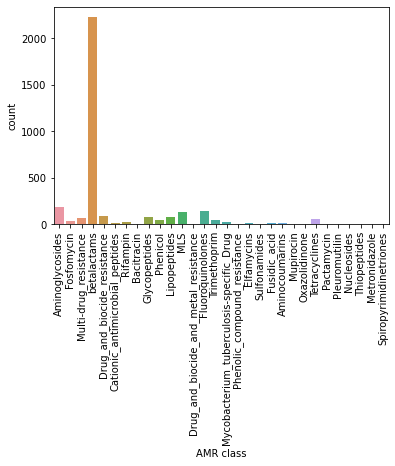

In [251]:
sns.countplot(mapping_df['AMR class'])
plt.xticks(rotation=90)
#plt.yscale('log')

In [252]:
amr_megares_mapped = amr_3dmm_ft.T.merge(amr_metadata_3dmm_df[['ARO Accession','Reference DB']].astype(str),left_index=True,right_index=True)
amr_megares_mapped = amr_megares_mapped.set_index('ARO Accession')
amr_megares_mapped = amr_megares_mapped.merge(mapping_df.astype(str),left_index=True,right_on='ARO')
amr_megares_mapped.set_index('ARO',inplace=True)
amr_megares_mapped.drop(columns = ['Reference DB','MEG','AMR class'],inplace=True)
amr_megares_mapped = amr_megares_mapped.T
amr_megares_mapped.index.names = ['sample_name']

# removes duplicate observations 
amr_megares_mapped = amr_megares_mapped.loc[:,~amr_megares_mapped.columns.duplicated(keep='first')]
amr_megares_mapped = amr_megares_mapped.loc[~amr_megares_mapped.index.duplicated(keep='first')]

In [253]:
mapping_metadata = mapping_df.set_index('ARO')
mapping_metadata.rename(columns={'AMR class':'Taxon'},inplace=True)
mapping_metadata.index.names = ['Feature ID']
mapping_metadata = mapping_metadata[~mapping_metadata.index.duplicated(keep='first')]

In [254]:
megares_check = pd.DataFrame(amr_megares_mapped.sum(axis=1),columns=['%'])

In [256]:
megares_check_merged = megares_check.merge(files_3dmm_merged,left_index=True, right_on='sample_name')
megares_check_merged['%'] = megares_check_merged['%'] * 100 #to turn into %

In [257]:
megares_check_merged.set_index('sample_name',inplace=True)

<AxesSubplot:title={'center':' Slope: 1.277e+00, r: 0.896, p-value: 1.399722111268234e-136'}, xlabel='%', ylabel='AMR_mapped_reads (%)'>

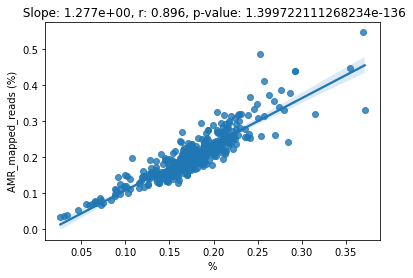

In [258]:
# sanity check of tight correlation between original AMR profiles and 
# MEGAres ontology mapped profiles
res = stats.linregress(megares_check_merged['%'],
                       megares_check_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
sns.regplot(x='%',y='AMR_mapped_reads (%)',data=megares_check_merged)

In [263]:
#Cast taxonomy as qiime2 artifacts to collapse feature_table on AMR Class
MEGARES_taxonomy = Artifact.import_data('FeatureData[Taxonomy]', mapping_metadata[['Taxon']])

In [264]:
amr_megares_ft = Artifact.import_data('FeatureTable[Frequency]', amr_megares_mapped.fillna(0))

In [265]:
megares_mapped_genes = amr_megares_ft.view(pd.DataFrame).columns.astype(str)

In [266]:
amr_metadata_3dmm_df['ARO Accession'] = amr_metadata_3dmm_df['ARO Accession'].astype(str)

In [267]:
amr_metadata_3dmm_df.loc[amr_metadata_3dmm_df['ARO Accession'].isin(megares_mapped_genes)]['Reference DB'].value_counts()

Resistomes & Variants          412
CARD                           212
CARD; Resistomes & Variants     66
Name: Reference DB, dtype: int64

In [268]:
# collapse feature_table on AMR Class
amr_megares_ft_class_collpased = taxa.methods.collapse(amr_megares_ft,MEGARES_taxonomy,1).collapsed_table

In [269]:
collapsed_megares_check = pd.DataFrame(amr_megares_ft_class_collpased.view(pd.DataFrame).sum(1),columns=['%'])

In [270]:
collapsed_megares_check_merged = collapsed_megares_check.merge(files_3dmm_merged,left_index=True, right_on='sample_name')
collapsed_megares_check_merged['%'] = collapsed_megares_check_merged['%'] * 100 #to turn into %

<AxesSubplot:title={'center':' Slope: 1.277e+00, r: 0.896, p-value: 1.3997221112679951e-136'}, xlabel='%', ylabel='AMR_mapped_reads (%)'>

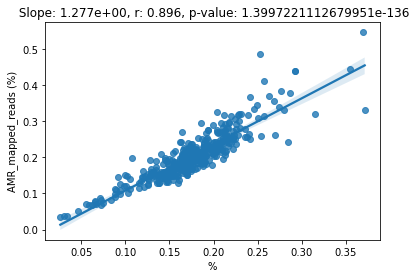

In [271]:
# sanity check of tight correlation between original AMR profiles and 
# MEGAres ontology mapped profiles, collapsed at AMR class
res = stats.linregress(collapsed_megares_check_merged['%'],
                       collapsed_megares_check_merged['AMR_mapped_reads (%)'])
plt.title(f" Slope: {res.slope:.3e}, r: {res.rvalue:.3f}, p-value: {res.pvalue}")
sns.regplot(x='%',y='AMR_mapped_reads (%)',data=collapsed_megares_check_merged)

In [272]:
plot_data = np.log10(amr_megares_ft_class_collpased.view(pd.DataFrame)).melt(var_name='AMR Class',
                                                                        value_name='RelativeAbundance')
plot_data = plot_data.replace(-np.inf,np.nan)

In [273]:
for class_ in plot_data['AMR Class'].unique():
    median_ = plot_data.loc[plot_data['AMR Class']==class_,'RelativeAbundance'].median()
    denom_ = plot_data.loc[plot_data['AMR Class']==class_].shape[0]
    prevalence_ = sum(~plot_data.loc[plot_data['AMR Class']==class_,'RelativeAbundance'].isnull())/denom_
    plot_data.loc[plot_data['AMR Class']==class_,'median_ra']=median_
    plot_data.loc[plot_data['AMR Class']==class_,'prevalence']=prevalence_

In [274]:
plot_data.sort_values(by=['prevalence','median_ra'])['AMR Class'].unique()

array(['Thiopeptides', 'Elfamycins', 'Fusidic_acid', 'Aminocoumarins',
       'Sulfonamides', 'Nucleosides', 'Trimethoprim', 'Fluoroquinolones',
       'Phenicol', 'betalactams', 'Phenolic_compound_resistance',
       'Tetracyclines', 'Mupirocin', 'Fosfomycin', 'MLS',
       'Cationic_antimicrobial_peptides', 'Lipopeptides',
       'Aminoglycosides', 'Drug_and_biocide_resistance',
       'Multi-drug_resistance', 'Glycopeptides', 'Rifampin'], dtype=object)

/Users/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


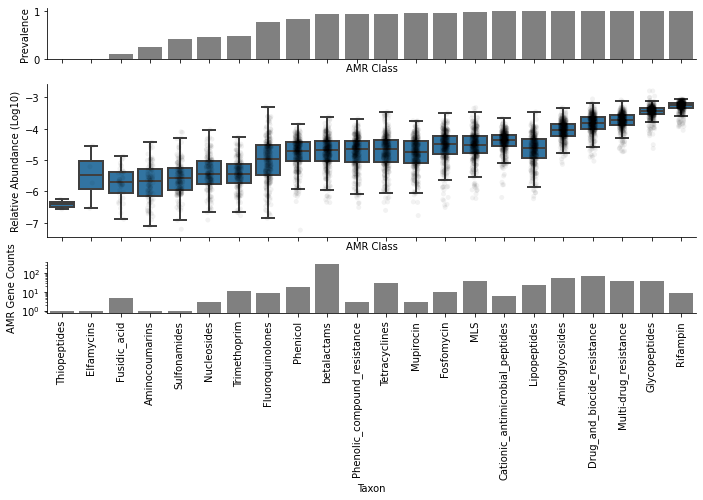

In [275]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(10,5),gridspec_kw={'height_ratios': [1,3, 1]})
sns.barplot(x='AMR Class',y='prevalence',data=plot_data.sort_values(by=['prevalence','median_ra']),
            ax=ax1,color='gray')
sns.stripplot(x='AMR Class',y='RelativeAbundance',data=plot_data.sort_values(by=['prevalence','median_ra']),
              alpha=0.05,color='black',ax=ax2)
sns.boxplot(x='AMR Class',y='RelativeAbundance',data=plot_data.sort_values(by=['prevalence','median_ra'])
            ,color='tab:blue',linewidth=2,ax=ax2,fliersize=0)
sns.countplot(mapping_metadata.loc[mapping_metadata.index.isin(amr_megares_mapped.columns)]['Taxon'],ax=ax3,
              order=plot_data.sort_values(by=['prevalence','median_ra'])['AMR Class'].unique(),color='gray')
ax3.set_yscale('log')
ax2.set_ylabel('Relative Abundance (Log10)')
ax1.set_ylabel('Prevalence')
ax3.set_ylabel('AMR Gene Counts')
for axes in [ax1,ax2,ax3]:
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['top'].set_visible(False)

plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig('./figs/AMR_class.svg')

In [276]:
plot_data.groupby('AMR Class').median().sort_values(by='prevalence')


,RelativeAbundance,median_ra,prevalence
AMR Class,,,
Thiopeptides,-6.410744,-6.410744,0.005102
Elfamycins,-5.472797,-5.472797,0.010204
Fusidic_acid,-5.710169,-5.710169,0.102041
Aminocoumarins,-5.663697,-5.663697,0.252551
Sulfonamides,-5.581597,-5.581597,0.423469
Nucleosides,-5.444235,-5.444235,0.446429
Trimethoprim,-5.436186,-5.436186,0.484694
Fluoroquinolones,-4.964394,-4.964394,0.755102
Phenicol,-4.697365,-4.697365,0.831633


In [277]:
mapping_metadata.loc[mapping_metadata.index.isin(amr_megares_mapped.columns)]['Taxon'].nunique()

22

In [279]:
AMR_per_module_df = pd.DataFrame(index=metadata_w_alpha['module'].unique())
for module in metadata_w_alpha['module'].unique():
    samples_in_module = metadata_w_alpha.loc[metadata_w_alpha['module']==module].index
    subset_ft = amr_3dmm_ft.loc[amr_3dmm_ft.index.isin(samples_in_module)]
    AMR_genes_n = sum(subset_ft.sum()>0)
    AMR_per_module_df.loc[module,'AMR gene count']=AMR_genes_n


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

US Lab vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.681e-01 U_stat=7.930e+02
Node 1 vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.459e-01 U_stat=3.312e+03
JLP vs. JPM: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.059e-05 U_stat=9.200e+01
PMM vs. Node 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.030e-01 U_stat=2.644e+03
JPM vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.690e-01 U_stat=6.490e+02
Node 1 vs. Airlock: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.198e-01 U_stat=1.680e+02
Columbus vs. Node 2: Mann-Whitney-Wilcoxon test two-sided with Benjam

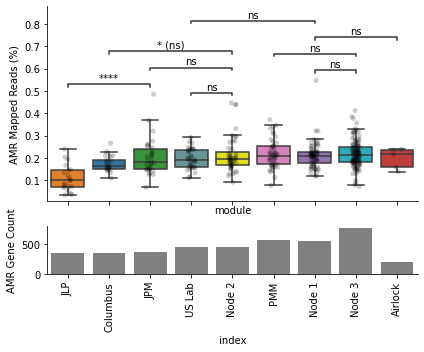

In [280]:
order_ = collapsed_megares_check_merged.sort_values(by='AMR_percent_median')['module'].unique()
#pairs were defined by physical interconnectedness of modules 

f, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(6,5),gridspec_kw={'height_ratios': [4,1]})


sns.boxplot(x='module',y='AMR_mapped_reads (%)',data=files_3dmm_merged.sort_values(by='AMR_percent_median'),fliersize=0,ax=ax1,
           palette=module_colors)
sns.stripplot(x='module',y='AMR_mapped_reads (%)',data=files_3dmm_merged.sort_values(by='AMR_percent_median'),color='black',alpha=0.2,ax=ax1)
plt.xticks(rotation=90)

# ax1.set_ylim(0,0.7)
pairs = [('JPM','JLP'),('Node 3','PMM'),('Node 2','JPM'),('Node 2','Columbus'),('Node 2','US Lab'),
        ('Node 1','US Lab'),('Airlock','Node 1'),('Node 1','Node 3')]
annot = Annotator(ax1, pairs, data=files_3dmm_merged, x='module', y='AMR_mapped_reads (%)', order=order_)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2,comparisons_correction='fdr_bh')
annot.apply_test()
ax1, test_results = annot.annotate()

sns.barplot(x='index',y='AMR gene count',data=AMR_per_module_df.reset_index(),ax=ax2,
              order=collapsed_megares_check_merged.sort_values(by=['AMR_percent_median'])['module'].unique(),color='gray')

for axes in [ax1,ax2]:
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['top'].set_visible(False)

ax2.set_ylabel('AMR Gene Count')
ax1.set_ylabel('AMR Mapped Reads (%)')
plt.tight_layout()
plt.savefig('./figs/AMR_per_module.svg')

In [281]:
amr_metadata_3dmm_df['Reference DB'].value_counts()

Resistomes & Variants          625
CARD                           340
CARD; Resistomes & Variants    100
Name: Reference DB, dtype: int64

# MAG AMR

In [282]:
pantoea_amr = pd.read_csv('./data/pantoea_amr.txt',sep='\t')

In [283]:
pantoea_amr['Specifics'].unique()

array(['ISS-Internal Surface', 'Urban', 'Saliva', 'Urine', 'Blood'],
      dtype=object)

In [284]:
amr_counts_df = pd.DataFrame(index=pantoea_amr['Bin.ID'].unique())
for genome_ in pantoea_amr['Bin.ID'].unique():
    AMR_gene_count = pantoea_amr.loc[pantoea_amr['Bin.ID']==genome_]['Protein.identifier'].nunique()
    amr_counts_df.loc[genome_,'AMR gene count']=AMR_gene_count
    amr_counts_df.loc[genome_,'category']=pantoea_amr.loc[pantoea_amr['Bin.ID']==genome_]['Category'].unique()
    amr_counts_df.loc[genome_,'source']=pantoea_amr.loc[pantoea_amr['Bin.ID']==genome_]['Source'].unique()
    amr_counts_df.loc[genome_,'Specifics']=pantoea_amr.loc[pantoea_amr['Bin.ID']==genome_]['Specifics'].unique()
    

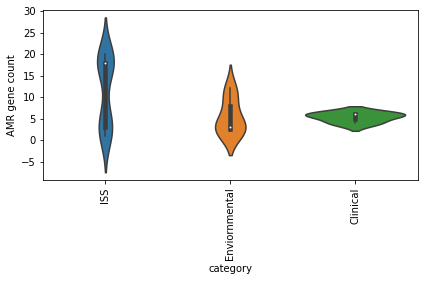

In [285]:
sns.violinplot(x='category',y='AMR gene count',data=amr_counts_df)
plt.xticks(rotation=90)

plt.tight_layout()

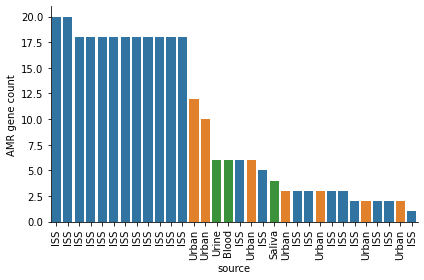

In [286]:
amr_counts_df.loc[amr_counts_df['Specifics']=='ISS-Internal Surface','Specifics']='ISS'
fig, ax = plt.subplots()

lut = dict(zip(amr_counts_df['category'].unique(),
               sns.color_palette("tab10",n_colors=3)))
col_colors = amr_counts_df.sort_values(by='AMR gene count',ascending=False)['category'].map(lut)

sns.barplot(x='index',y='AMR gene count',data=amr_counts_df.sort_values(by='AMR gene count',ascending=False).reset_index(),palette=col_colors)
labels_ = amr_counts_df.sort_values(by='AMR gene count',ascending=False)['Specifics']
ticks = ax.get_xticks().tolist()
plt.xticks(rotation=90,ticks=ticks,labels=labels_)
plt.tight_layout()
plt.xlabel('source')

for axes in [ax]:
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['top'].set_visible(False)

plt.savefig('./figs/amr_gene_counts_pantoea_comparison.svg')

/var/folders/90/7sftvg657kdcfk9d88mj7zph0000gp/T/ipykernel_15505/215415535.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


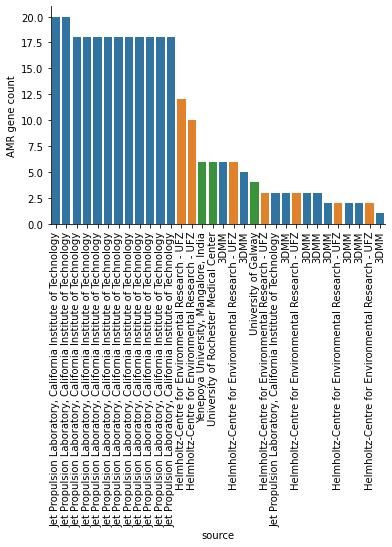

In [287]:
fig, ax = plt.subplots()

lut = dict(zip(amr_counts_df['category'].unique(),
               sns.color_palette("tab10",n_colors=3)))
col_colors = amr_counts_df.sort_values(by='AMR gene count',ascending=False)['category'].map(lut)

sns.barplot(x='index',y='AMR gene count',data=amr_counts_df.sort_values(by='AMR gene count',ascending=False).reset_index(),palette=col_colors)
labels_ = amr_counts_df.sort_values(by='AMR gene count',ascending=False)['source']
ticks = ax.get_xticks().tolist()
plt.xticks(rotation=90,ticks=ticks,labels=labels_)
plt.tight_layout()
plt.xlabel('source')

for axes in [ax]:
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['top'].set_visible(False)

In [288]:
from matplotlib_venn import venn3, venn3_circles

In [289]:
env_amr_genes = set(pantoea_amr.loc[pantoea_amr['Category']=='Enviornmental']['Gene.symbol'])
clin_amr_genes = set(pantoea_amr.loc[pantoea_amr['Category']=='Clinical']['Gene.symbol'])
iss_amr_genes = set(pantoea_amr.loc[pantoea_amr['Category']=='ISS']['Gene.symbol'])

/Users/rsalidob/miniconda3/envs/qiime2-2021.8/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


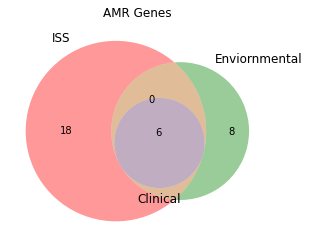

In [290]:
venn3([iss_amr_genes,env_amr_genes,clin_amr_genes],set_labels=['ISS','Enviornmental','Clinical'])
plt.title('AMR Genes')
plt.savefig('./figs/amr_venn.svg')

In [291]:
## ISS specific AMR genes relate to metallotolerance
iss_amr_genes-env_amr_genes

{'arsB',
 'blaOXA',
 'erm(C)',
 'fosB',
 'merA',
 'mupA',
 'pcoA',
 'pcoB',
 'pcoC',
 'pcoD',
 'pcoE',
 'pcoR',
 'pcoS',
 'silB',
 'silC',
 'silE',
 'silF',
 'silS'}